In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib ipympl
plt.rcParams['figure.figsize'] = [10, 4]
mpl.rc('image', cmap='gray')
import matplotlib.animation
writervideo = matplotlib.animation.FFMpegWriter(fps=30)

import numpy as np
import pandas as pd

import pims
import trackpy as tp
tp.quiet()
from PIL import Image, ImageDraw
import cv2

from tqdm import tqdm
import joblib

from scipy.spatial import distance_matrix
from scipy.ndimage import uniform_filter1d

import random

run_analysis_verb = False
show_verb = True
save_verb = True

# PRE PROCESSING

In [ ]:
@pims.pipeline
def crop(image, x1, y1, x2, y2):    
    npImage = np.array(image)
    # Create same size alpha layer with circle
    #alpha = Image.new('L', (920, 960), 0)
    alpha = Image.new('L', (920, 960), 0)

    draw = ImageDraw.Draw(alpha)
    draw.pieslice(((x1, y1), (x2, y2)), 0, 360, fill=255)

    # Convert alpha Image to numpy arrayf
    npAlpha = np.array(alpha)
    npImage = npImage[:, :, 1] * npAlpha
    
    ind = np.where(npImage == 0)
    # npImage[200, 200] color of the border to swap with the black
    npImage[ind] = npImage[200, 200]
    return npImage

In [ ]:
data = crop(pims.open('./data/movie.mp4'), 55, 55, 880, 880)
data_ref = pims.open('./data/movie.mp4')

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(data[0])
ax2.imshow(data_ref[0])
plt.tight_layout()
if save_verb: plt.savefig('./results/pre_processing.png', bbox_inches='tight')
if 1: 
    plt.show()
else:
    plt.close()

# TRACKING 

In [ ]:
# parameters of the tracking
dropSize = 31  
minMass = 2000
sep = 16
nDrops = 50

In [ ]:
# FEATURES LOCATION
nFrames = 100 # total number of frames of video --> len(data)
startFrame = 0
endFrame = startFrame + nFrames

f = tp.batch(data[startFrame:endFrame], dropSize, minmass = minMass, separation = sep, topn = nDrops, engine = 'numba')    
display(f)

In [ ]:
# ANOMALIES DETECTION

num = np.zeros(nFrames)
for i in range(nFrames):
    num[i] = len(f.loc[f['frame'] == i])

idx = np.where(num != nDrops)[0]
print(idx)

if len(idx) != 0:
    delta = np.zeros(len(idx)-1)
    for i in range(len(idx)-1):
        delta[i] = idx[i+1]-idx[i]
    print(delta)

In [ ]:
# FEATURES LINKING
""" f : DataFrame
    The DataFrame must include any number of column(s) for position and a
    column of frame numbers. By default, 'x' and 'y' are expected for
    position, and 'frame' is expected for frame number. See below for
    options to use custom column names.
search_range : float or tuple
    the maximum distance features can move between frames,
    optionally per dimension
pos_columns : list of str, optional
    Default is ['y', 'x'], or ['z', 'y', 'x'] when 'z' is present in f
t_column : str, optional
    Default is 'frame'
memory : integer, optional
    the maximum number of frames during which a feature can vanish
"""

t = tp.link_df(f, 150, memory = 2, link_strategy = 'hybrid', neighbor_strategy = 'KDTree', adaptive_stop = 1)
display(t)

In [ ]:
n = max(t.particle)
print(n)
random.seed(5)
colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(n)]
for i in range(max(t.particle)+1-n):
    colors.append("#00FFFF")
c = []
for p in t.particle:
    c.append(colors[p])
t["color"] = c


In [ ]:
lost_particles = []
for i in range(nFrames-1):
    a = t.loc[t.frame == i].sort_values('particle').particle.values
    b = t.loc[t.frame == i+1].sort_values('particle').particle.values
    ind = np.where(np.in1d(a, b)==False)[0]
    if ind.size > 0:
        lost_particles.append([i, a[ind]])

print("Total problems:", len(lost_particles))
if len(lost_particles) > 0: 
    print(f"First failure occurred at frame {lost_particles[0][0]}")
    f1 = lost_particles[0][0]
    f2 = lost_particles[0][0]+1
    print(t.loc[t.frame == f1].sort_values('particle').particle.values)
    print(t.loc[t.frame == f2].sort_values('particle').particle.values)

In [ ]:
if len(lost_particles)>0: 
    fig, (ax, ax1) = plt.subplots(1, 2)
    df = t.loc[t['frame'] == f1, ["x", "y", "color", "particle"]]
    ax.scatter(df.x, df.y, s=50, ec = "w", facecolor = df.color)
    #ax.scatter(df.loc[df.particle==43].x, df.loc[df.particle==43].y, s=100)
    #ax.scatter(df.loc[df.particle==82].x, df.loc[df.particle==82].y, s=100)
    ax.imshow(data[f1])

    df1 = t.loc[t['frame'] == f2, ["x", "y", "color"]]
    ax1.scatter(df1.x, df1.y, s=50, ec = "w", facecolor = df1.color)
    ax1.imshow(data[f2])

    plt.show()

In [ ]:
t1 = tp.filter_stubs(t, nFrames/2)
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())

In [ ]:
df = rawTrajs.loc[(rawTrajs.frame == 0) , ["x", "y", "color"]]
fig, ax = plt.subplots(1,1)
ax.scatter(df.x, df.y, facecolors = 'none', edgecolors = df.color, s = 150)
ax.imshow(data[0])
if save_verb: plt.savefig("../results/location_example.png",  bbox_inches='tight')
if show_verb: 
    plt.show()
else:
    plt.close()

fig = plt.figure()
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True

def update_graph(frame):
    df = rawTrajs.loc[(rawTrajs.frame == frame) & (rawTrajs.particle == red_particle_idx) , ["x","y","color"]]
    graph.set_offsets(df)
    graph.set_edgecolor(df.color)
    graph2.set_data(data[frame])
    title.set_text('frame = {}'.format(frame))
    return graph

ax = fig.add_subplot(111)
title = ax.set_title('frame = 0')
df = rawTrajs.loc[(rawTrajs.frame == 0) & (rawTrajs.particle == red_particle_idx), ["x","y","color"]]

graph = ax.scatter(df.x, df.y, facecolors = 'none', edgecolors = df.color, s = 150)

graph2 = ax.imshow(data[0])

fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, update_graph, 100, interval = 5, blit=False)
if 0: ani.save('../results/video/tracking.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
if anim_show_verb:
    plt.show()
else:
    plt.close()


# post merge tracking

In [ ]:
# parameters of the tracking
dropSize = 31  
minMass = 2000
sep = 16
nDrops = 49

# FEATURES LOCATION
nFrames = 100 # total number of frames of video --> len(data)
startFrame = 32269 + 100
endFrame = startFrame + nFrames

In [ ]:
data_preload = list(data[startFrame:])

In [ ]:
f = tp.batch(data_preload[:1000], dropSize, minmass = minMass, separation = sep, topn = nDrops, engine = 'numba')    
f.frame = f.frame + startFrame

In [ ]:
num = np.zeros(1000)
for i in range(1000):
    num[i] = len(f.loc[f['frame'] == i + startFrame])

idx = np.where(num != nDrops)[0]
print(idx)
if len(idx) != 0:
    delta = np.zeros(len(idx)-1)
    for i in range(len(idx)-1):
        delta[i] = idx[i+1]-idx[i]
    print(delta)

t = tp.link_df(f, 50, memory = 2, link_strategy = 'hybrid', neighbor_strategy = 'KDTree', adaptive_stop = 1)
t = tp.filter_stubs(t, 50)
# ANOMALIES DETECTION
n = max(t.particle)
print(n)
random.seed(5)
colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(n)]
for i in range(max(t.particle)+1-n):
    colors.append("#00FFFF")
c = []
for p in t.particle:
    c.append(colors[p])
t["color"] = c

display(t)

In [ ]:
df = t.loc[(t.frame == startFrame+100) , ["x", "y", "color"]]
fig, ax = plt.subplots(1, 1)
ax.scatter(df.x, df.y, facecolors = 'none', edgecolors = df.color, s = 50)
ax.imshow(data_preload[100])
plt.show()

In [ ]:
fig = plt.figure()
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True

def update_graph(frame):
    df = t.loc[t.frame == frame, ["x", "y", "color"]]
    graph.set_offsets(df)
    graph.set_edgecolor(df.color)
    graph2.set_data(data_preload[frame-startFrame])
    title.set_text('frame = {}'.format(frame))
    return graph

ax = fig.add_subplot(111)
title = ax.set_title('frame = 0')
df = t.loc[t.frame == startFrame, ["x", "y", "color"]]
graph = ax.scatter(df.x, df.y, facecolors = 'none', edgecolors = df.color, s = 50)
graph2 = ax.imshow(data_preload[0])

fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, update_graph, range(startFrame, startFrame + 1000), interval = 5, blit=False)
plt.show()

In [ ]:
df = t.loc[t['frame'] == f1, ["x", "y", "color", "particle"]]

fig, (ax, ax1) = plt.subplots(1, 2)
ax.scatter(df.x, df.y, s=50, ec = "w", facecolor = df.color)
ax.imshow(data[f1])
df1 = t.loc[t['frame'] == f2, ["x", "y", "color"]]
ax1.scatter(df1.x, df1.y, s=50, ec = "w", facecolor = df1.color)
ax1.imshow(data[f2])
plt.show()

In [ ]:
lost_particles = []
for i in range(nFrames-1):
    a = t.loc[t.frame == i].sort_values('particle').particle.values
    b = t.loc[t.frame == i+1].sort_values('particle').particle.values
    ind = np.where(np.in1d(a, b)==False)[0]
    if ind.size > 0:
        lost_particles.append([i, a[ind]])
print("Total problems:", len(lost_particles))
print(ind)

if len(lost_particles) > 0: 
    print(f"First failure occurred at frame {lost_particles[0][0]}")
    f1 = lost_particles[0][0]
    f2 = lost_particles[0][0]+1
    print(t.loc[t.frame == f1].sort_values('particle').particle.values)
    print(t.loc[t.frame == f2].sort_values('particle').particle.values)

if len(lost_particles)>0: 
    fig, (ax, ax1) = plt.subplots(1, 2)
    df = t.loc[t['frame'] == f1, ["x", "y", "color", "particle"]]
    ax.scatter(df.x, df.y, s=50, ec = "w", facecolor = df.color)
    #ax.scatter(df.loc[df.particle==43].x, df.loc[df.particle==43].y, s=100)
    #ax.scatter(df.loc[df.particle==82].x, df.loc[df.particle==82].y, s=100)
    ax.imshow(data[f1])

    df1 = t.loc[t['frame'] == f2, ["x", "y", "color"]]
    ax1.scatter(df1.x, df1.y, s=50, ec = "w", facecolor = df1.color)
    ax1.imshow(data[f2])

    plt.show()

# DIMENSION OF DROPLETS ANALYSIS

## TRACKPY RESULTS:

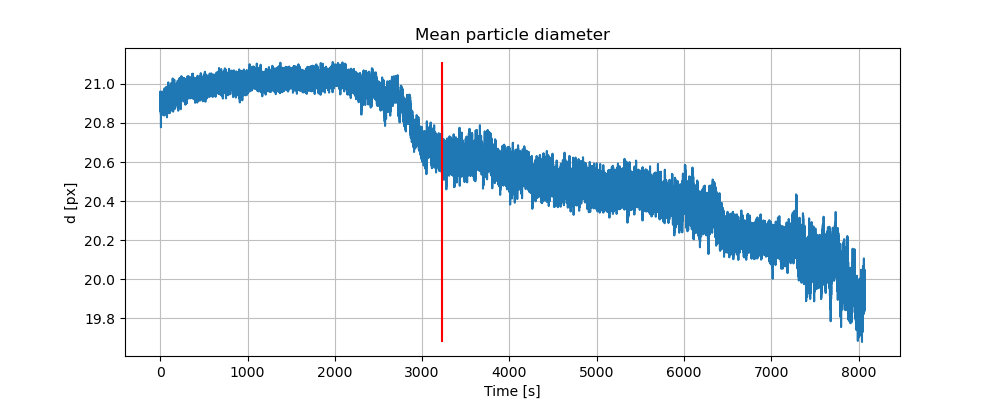

In [2]:
rawTrajs = pd.read_parquet("./results/parquet/full_movie_tracking.parquet")
mean_dim = rawTrajs.groupby("frame").mean()
merge_frame = 32269

fig, ax = plt.subplots(1, 1)
ax.plot(mean_dim.index/10, 2*mean_dim["size"])
ax.vlines(merge_frame/10, 2*mean_dim["size"].values.min(), 2*mean_dim["size"].max(), color="r")
ax.set(xlabel = "Time [s]", ylabel = "d [px]", title = "Mean particle diameter")
ax.grid(True, linestyle='-', color = '0.75')
if save_verb: plt.savefig("./results/dimension_analysis/mean_diameter_trackpy.png", bbox_inches='tight')
if show_verb:
    plt.show()
else:
    plt.close()

In [10]:
# windowed ?
nFrames = len(mean_dim)
print(nFrames)
# WINDOWED ANALYSIS PARAMETERS
window = 3200 # 320 s
stride = 100 # 10 s
print(f"window of {window/10} s, stride of {stride/10} s")
startFrames = np.arange(0, nFrames-window, stride, dtype=int)
endFrames = startFrames + window
nSteps = len(startFrames)
print(f"number of steps: {nSteps}")

# mean and std droplet diameter per frame
mean_d_wind = np.zeros(nSteps)
std_d_wind = np.zeros(nSteps)
for i, start in enumerate(startFrames):
    mean_d_wind[i] = np.mean(2*mean_dim["size"][start:start+window])
    std_d_wind[i] = np.std(2*mean_dim["size"][start:start+window])

80700
window of 320.0 s, stride of 10.0 s
number of steps: 775


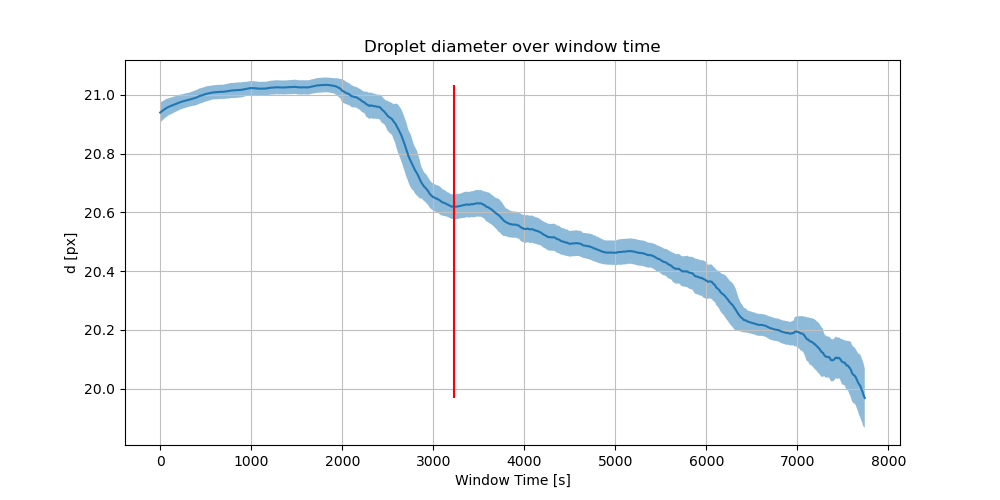

In [11]:
fig, ax = plt.subplots(1, 1, figsize = (10, 5))
ax.plot(startFrames/10, mean_d_wind)
ax.vlines(merge_frame/10, mean_d_wind.min(), mean_d_wind.max(), color="r")
ax.fill_between(startFrames/10, mean_d_wind - std_d_wind, mean_d_wind + std_d_wind, alpha=0.5)
ax.set(xlabel = "Window Time [s]", ylabel = "d [px]", title = "Droplet diameter over window time")
ax.grid(True, linestyle='-', color = '0.75')
plt.show()

## HOUGH CIRCLE RESULTS:

In [ ]:
@pims.pipeline
def crop2(image, x1, y1, x2, y2):    
    #image = cv2.GaussianBlur(image, ksize = [7,7], sigmaX = 1.5, sigmaY = 1.5)
    npImage = np.array(image)
    # Create same size alpha layer with circle
    alpha = Image.new('L', (920, 960), 0)

    draw = ImageDraw.Draw(alpha)
    draw.pieslice(((x1, y1), (x2, y2)), 0, 360, fill=255)

    # Convert alpha Image to numpy array
    npAlpha = np.array(alpha)
    npImage = npImage[:, :, 1] * npAlpha
    
    ind = np.where(npImage == 0)
    # npImage[200, 200] color of the border to swap with the black
    npImage[ind] = npImage[200, 200]
    npImage = cv2.medianBlur(npImage, 5)
    return npImage

@joblib.delayed
def loc_frame(correct_n, frame, img, parameters):
	temp = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT_ALT, **parameters)
	if temp.shape[1] == correct_n:
		return np.hstack((temp[0], (np.ones((correct_n, 1), dtype=int)*frame), np.ones((correct_n, 1), dtype=int)*temp.shape[1]))
	else: 
		return np.hstack((np.zeros((correct_n, 3)), (np.ones((correct_n, 1), dtype=int)*frame), np.ones((correct_n, 1), dtype=int)*temp.shape[1]))


In [ ]:
# parameters of the HoughCircles function
parameters_pre_merge = {"dp": 1.5, "minDist": 15, "param1": 100, "param2": 0.8, "minRadius": 15, "maxRadius": 25}
parameters_post_merge = {"dp": 1.5, "minDist": 10, "param1": 100, "param2": 0.8, "minRadius": 10, "maxRadius": 30}
# load data
data = crop2(pims.open('./data/movie.mp4'), 40, 55, 895, 910)
nFrames = len(data)
merge_frame = 32269

if 0:
	# pre merge detection
	parallel = joblib.Parallel(n_jobs = -1)
	temp = parallel(
		loc_frame(50, frame, data[frame], parameters_pre_merge)
		for frame in tqdm( range(merge_frame) )
	)
	pre_merge_droplets = np.array(temp).reshape(merge_frame*50, 5)
	pre_merge_droplets = pd.DataFrame(pre_merge_droplets, columns = ["x", "y", "d", "frame", "nDroplets"])
	pre_merge_droplets.to_parquet("pre_merge_droplets2.parquet")
	pre_merge_droplets.replace(0, np.nan, inplace=True)
	pre_merge_droplets.loc[:50, "frame"] = 0
	
	parallel = joblib.Parallel(n_jobs = -1)
	temp = parallel(
		loc_frame(49, frame, data[frame], parameters_post_merge)
		for frame in tqdm( range(merge_frame, nFrames) )
	)
	post_merge_droplets = np.array(temp).reshape((nFrames-merge_frame)*49, 5)
	post_merge_droplets = pd.DataFrame(post_merge_droplets, columns = ["x", "y", "d", "frame", "nDroplets"])
	post_merge_droplets.to_parquet("post_merge_droplets2.parquet")
	post_merge_droplets.replace(0, np.nan, inplace=True)

else:
	pre_merge_droplets = pd.read_parquet("./pre_merge_droplets.parquet").replace(0, np.nan)
	pre_merge_droplets.loc[:50, "frame"] = 0
	post_merge_droplets = pd.read_parquet("./post_merge_droplets.parquet").replace(0, np.nan)
	
pre_merge_err_frames = np.where(pre_merge_droplets.groupby("frame").mean().x.isna())[0]
post_merge_err_frames = merge_frame + np.where(post_merge_droplets.groupby("frame").mean().x.isna())[0]
pre_merge_errors = int(len(pre_merge_err_frames))
post_merge_errors = int(len(post_merge_err_frames))

print(f"Errors before merging: {pre_merge_errors} --> {np.round(100*pre_merge_errors/merge_frame, 2)} %")
print(f"Errors after merging:  {post_merge_errors} --> {np.round(100*post_merge_errors/(nFrames-merge_frame), 2)} %")

In [ ]:
# load data
data = crop2(pims.open('./data/movie.mp4'), 40, 55, 895, 910)
merge_frame = 32269
if 1: data_preload = list(data[merge_frame:len(data)])

# pre merge test
if 0:
	parameters_pre_merge = {"dp": 1.5, "minDist": 15, "param1": 100, "param2": 0.9, "minRadius": 15, "maxRadius": 25}
	startFrame = 0
	endFrame = 5000 #merge_frame
	frames = np.arange(startFrame, endFrame, 1)
	n = len(frames)
	parallel = joblib.Parallel(n_jobs = -2)
	temp = parallel(
	    loc_frame(50, frame, data[frame], parameters_pre_merge)
	    for frame in tqdm( frames )
	)
	temp = pd.DataFrame(np.array(temp).reshape(n*50, 5), columns = ["x", "y", "d", "frame", "nDroplets"])
	temp = temp.replace(0, np.nan)
	temp.loc[:50, "frame"] = 0
	print(temp)

	err_frames = np.where(temp.groupby("frame").mean().x.isna())[0]
	print(f"Errors before merging:  {len(err_frames)} --> {np.round(100*len(err_frames)/n, 2)} %")

	fig, (ax, ax1) = plt.subplots(2, 1, figsize = (10, 4))
	ax.plot(temp.groupby("frame").mean().nDroplets, "o", ms = 1)
	ax1.plot(temp.d, "o", ms = 1)
	ax.set_xlabel("Frame")
	ax.set_ylabel("Number of droplets")
	ax.set_title("Number of droplets detected per frame")
	plt.show()

# Post merge test
if 1:
	parameters_post_merge = {"dp": 1.5, "minDist": 14, "param1": 100, "param2": 0.8, "minRadius": 14, "maxRadius": 25}
	startFrame = merge_frame
	endFrame =  len(data) #startFrame + 5000 #len(data)
	frames = np.arange(startFrame, endFrame, 1)
	n = len(frames)

	parallel = joblib.Parallel(n_jobs = -1)
	temp2 = parallel(
	    loc_frame(49, frame, data_preload[frame-startFrame], parameters_post_merge)
	    for frame in tqdm( frames )
	) 
	temp2 = pd.DataFrame(np.array(temp2).reshape(n*49, 5), columns = ["x", "y", "d", "frame", "nDroplets"])
	temp2 = temp2.replace(0, np.nan)
	print(temp2)

	err_frames2 = np.where(temp2.groupby("frame").mean().x.isna())[0]
	print(f"Errors after merging:  {len(err_frames2)} --> {np.round(100*len(err_frames2)/n, 2)} %")

	fig, (ax, ax1) = plt.subplots(2, 1, figsize = (10, 4))
	ax.plot(temp2.nDroplets)
	ax1.plot(temp2.d)
	ax.set_xlabel("Frame")
	ax.set_ylabel("Number of droplets")
	ax.set_title("Number of droplets detected per frame")
	plt.show()

In [ ]:
problem_frame = np.where(temp.groupby("frame").mean().nDroplets == 47)[0][0] + merge_frame
temp = cv2.HoughCircles(data[problem_frame], cv2.HOUGH_GRADIENT_ALT, **parameters)

In [ ]:
fig, (ax, ax1) = plt.subplots(2, 1, figsize = (10, 10))
ax.imshow(data[problem_frame], cmap = "gray")
for i in range(temp.shape[1]):
    ax.add_patch(plt.Circle((temp[0][i][0], temp[0][i][1]), temp[0][i][2], color = "r", fill = False))
ax1.plot(temp[0][:, 2], "o", ms = 1)
plt.show()


In [ ]:
fig, ax = plt.subplots(1, 1)
ax.plot(pre_merge_droplets.groupby("frame").mean().nDroplets, label="Before merging")
ax.plot(post_merge_droplets.groupby("frame").mean().nDroplets, label="After merging")
ax.set(xlabel="Frame", ylabel="Mean number of droplets")
ax.grid()
ax.legend()
if save_verb: plt.savefig("./results/dimension_analysis/mean_nDroplets.png", bbox_inches='tight')
if show_verb:
    plt.show()
else:
    plt.close()

In [ ]:
pre_merge_mean_dim = pre_merge_droplets.groupby("frame").mean().d.values
post_merge_mean_dim = post_merge_droplets.groupby("frame").mean().d.values
mean_dim_hough = np.append(pre_merge_mean_dim, post_merge_mean_dim)

fig, (ax,ax1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [2, 1]})
ax.plot(mean_dim_hough)
ax.vlines(merge_frame, np.nanmin(mean_dim_hough), np.nanmax(mean_dim_hough), color="r")
ax.set(xlabel="Frame", ylabel="Mean diameter")
ax.grid()
ax1.hist(np.argwhere(np.isnan(mean_dim_hough)), bins = np.arange(0, len(data), 320), cumulative=True, histtype="step")
ax1.set(xlabel="Frame", ylabel="Cumulative number of errors")
plt.tight_layout()
if save_verb: plt.savefig("./results/dimension_analysis/mean_dim_hough.png",  bbox_inches = 'tight')
if show_verb:
    plt.show()
else:
    plt.close()
plt.show()

# confront betwee trackpy and hough results
fig, ax = plt.subplots(1, 1)
ax.plot(2*mean_dim, label="Trackpy")
ax.plot(mean_dim_hough, label="Hough")
ax.vlines(merge_frame, np.nanmin(mean_dim_hough), np.nanmax(mean_dim_hough), color="r")
ax.set(xlabel="Frame", ylabel="Mean diameter")
ax.grid()
ax.legend()
if save_verb: plt.savefig("./results/dimension_analysis/mean_dim_comparison.png",  bbox_inches='tight')
if show_verb:
    plt.show()
else:
    plt.close()

In [ ]:
# match detected particles to rawTrajs particle index:
ids = np.zeros((100, 50), dtype=int)
err_count = 0
for frame in tqdm(range(100)):
    if frame in error_frames:
        continue
        #temp = err_circles[err_count]
        #err_count += 1
    else:
        temp = detected_circles[frame]

    dist_mat = distance_matrix(temp[:, :2], rawTrajs.loc[rawTrajs.frame==frame, ["x", "y"]])
    ids[frame] = np.argmin(dist_mat, axis = 1)

colors = np.array(["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(50)])
fig, ax = plt.subplots(1, 1)
for i in range(50):
    ax.scatter(detected_circles[0, ids[0], 0], detected_circles[0, ids[0], 1], color = colors[i])
ax.scatter(rawTrajs.loc[rawTrajs.frame==0, ["x"]], rawTrajs.loc[rawTrajs.frame==0, ["y"]], color = colors)
ax.imshow(data_preload[0])
plt.show()

In [ ]:
def analyze_error(img, parameters, plot):
    temp = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT_ALT, **parameters)[0]
    print(f"Found {temp.shape[0]} circles")
    # compute distance between detected circles
    dist_list = []
    for i in range(temp.shape[0]):
        for j in range(i):
            dist_list.append(np.linalg.norm(temp[i, :2] - temp[j, :2]))
    # find the two circles that are the closest
    problems_id = []
    for i in range(temp.shape[0]):
        for j in range(i):
            if np.linalg.norm(temp[i, :2] - temp[j, :2]) == min(dist_list):
                problems_id = [i, j]
                #print("Circles ID:", problems_id, "found at distance:", np.linalg.norm(temp[i, :2] - temp[j, :2]))

    # prepare the circles for plotting, different color for the two problematic circles
    circles_plot = []
    for i in range(temp.shape[0]):
        if (i == problems_id[0]) or (i == problems_id[1]):
            circles_plot.append(plt.Circle((temp[i, 0], temp[i, 1]), temp[i, 2], color='r', fill=False))
        else:
            circles_plot.append(plt.Circle((temp[i, 0], temp[i, 1]), temp[i, 2], color='b', fill=False))
    if plot:
        # plot the image with the circles
        fig, ax = plt.subplots(1, 1)
        ax.imshow(img)
        for i in range(temp.shape[0]):
            ax.add_artist(circles_plot[i])
        plt.show()
    return 0

In [ ]:
if 0:
    data_preload_pre_merge = list(data[pre_merge_err_frames[0]:pre_merge_err_frames[10]])
    data_preload_post_merge = list(data[post_merge_err_frames[0]:post_merge_err_frames[10]])

In [ ]:
print("Pre merge -> 50 droplets")
for i in range(10):
    analyze_error(data_preload_pre_merge[i], parameters, False)
print("Post merge -> 49 droplets ")
for i in range(10):
    analyze_error(data_preload_post_merge[i], parameters, False)

# estimate error in the tracking

I note that between frames 18300 and 18900 a droplet 40 seems stable and isolated.\
Then applying a rectangular mask around it I compute the "benchmark" position of the droplet using Canny Edge Detection and Hough Transform.\
Finally I confront the tracking result with the benchmark and different window sizes of smoothing.

In [ ]:
# apply mask to perform edge detection only on the benchmark particle
@pims.pipeline
def crop2(image, x1, y1, x2, y2):   
    npImage = np.array(image)
    alpha = Image.new('L', (920, 960), 0)
    draw = ImageDraw.Draw(alpha)
    draw.rectangle([(x1, y1), (x2, y2)], fill = 255)
    npAlpha = np.array(alpha)
    npImage = npImage[:, :, 1] * npAlpha
    return npImage

In [ ]:
startFrame = 18300
endFrame = 18900
framesArray = np.arange(startFrame, endFrame, 1) 

rawTrajs = pd.read_parquet("./results/parquet/pre_merge_tracking.parquet")
benchmark_particle_id = 40
print("Benchmark particle:", benchmark_particle_id)
rawTraj = rawTrajs.loc[(rawTrajs.frame.between(startFrame, endFrame-1)) & (rawTrajs.particle == benchmark_particle_id)]
if 1: ref = list(pims.open('./data/movie.mp4')[startFrame:endFrame])

In [ ]:
# apply mask to perform edge detection only on the benchmark particle
y1 = rawTraj.iloc[0].y - 50
x1 = rawTraj.iloc[0].x - 50
y2 = rawTraj.iloc[0].y + 110
x2 = rawTraj.iloc[0].x + 120
if 1: ref_masked = list(crop2(pims.open('./data/movie.mp4'), x1, y1, x2, y2)[startFrame:endFrame])

In [ ]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize = (8, 6))
ax.imshow(ref[0])
ax.scatter(rawTraj.iloc[0].x, rawTraj.iloc[0].y, s=150, facecolors='none', edgecolors='b')
ax.set(title = "Selection of benchmark particle", xlabel = "x [px]", ylabel = "y [px]")
ax1.imshow(ref_masked[0])
ax1.scatter(rawTraj.iloc[0].x, rawTraj.iloc[0].y, s=150, facecolors='none', edgecolors='b')
ax1.set(title = "Masked video", xlabel = "x [px]")
plt.tight_layout()
plt.savefig("./results/error_estimation/masked_frame.png", bbox_inches='tight')
plt.show()

In [ ]:
# needed to check that only particle 40 is selected by the mask
fig = plt.figure()
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True

def update_graph(frame):
    df = rawTraj.loc[rawTraj.frame == startFrame + frame, ["x","y", "color"]]
    graph.set_offsets(df)
    graph2.set_data(ref_masked[frame])
    title.set_text('frame = {}'.format(startFrame + frame))
    return graph

ax = fig.add_subplot(111)
title = ax.set_title(f'frame = {startFrame}')
df = rawTraj.loc[rawTraj.frame == startFrame, ["x","y", "color"]]

graph = ax.scatter(df.x, df.y, facecolors = 'none', edgecolors= df.color, s = 150)

graph2 = ax.imshow(ref_masked[0])

fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, update_graph, endFrame-startFrame, interval = 2, blit=False)
plt.show()

In [ ]:
circles = []
problems = 0

for i in tqdm(range(0, len(ref_masked))):
    img = ref_masked[i]
    """
                    -- this works fine !!!!! --
    # Apply Canny Edge Detection to find edges in the image
    edges = cv2.Canny(img, 30, 30)
    # Apply the Hough Transform to find circles in the image 
    temp = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, 1, minDist=20, param1=50, param2=30, minRadius=0, maxRadius=0)
    if temp is not None:
        circles.append(temp[0][0])
   """
    
    # this gives better results
    temp = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT_ALT, 1.5, minDist=1, param1=300, param2=0.6, minRadius=10, maxRadius=21)
    if temp is not None:
        circles.append(temp[0][0])
        
    else:
        break
        problems += 1
print("Number of problems:", problems)

In [ ]:
x = np.zeros(len(circles))
y = np.zeros(len(circles))
d = np.zeros(len(circles))

for i in range(len(circles)):
    x[i] = circles[i][0]
    y[i] = circles[i][1]
    d[i] = circles[i][2]
    
benchmark_traj = pd.DataFrame({"x": x, "y": y, "d": d})

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6))
ax.plot(np.arange(startFrame, endFrame, 1), benchmark_traj.d, label = "benchmark")
ax.plot(np.arange(startFrame, endFrame, 1), 2*rawTraj["size"], label = "traj")
ax.legend()
plt.show()

In [ ]:
c1 = plt.Circle(( x[100] , y[100] ), d[100], fill = False, color = "red")
c2 = plt.Circle((rawTraj.x.values[100], rawTraj.y.values[100]), 2*rawTraj["size"].values[100], fill = False, color="blue")

fig, (ax, ax1) = plt.subplots(1, 2, figsize = (10, 8))
ax.imshow(ref_masked[100])
ax.add_artist(c1)
ax.scatter(x[100], y[100], color = "red")
ax.set(xlim = (x1, x2), ylim = (y1, y2))
ax1.imshow(ref_masked[100])
ax1.add_artist(c2)
ax1.scatter(rawTraj.x.values[100], rawTraj.y.values[100], color = "blue")
ax1.set(xlim = (x1, x2), ylim = (y1, y2))
plt.show()

## POSITION ERROR

In [ ]:
tracking_pos = np.sqrt(rawTraj.x**2 + rawTraj.y**2)

benchmark_pos = np.sqrt(x**2 + y**2)
mse_raw = ((benchmark_pos - tracking_pos)**2).mean()
print("MSE with raw trajectory:", mse_raw)

In [ ]:
from scipy.signal import savgol_filter
def get_smooth_trajs(trajs, nDrops, windLen, orderofPoly):
    # Trajectory Smoothing: using a Savgol Filter in order to drop the noise due to the tracking procedure
    ret = trajs.copy()
    for i in range(nDrops):
        ret.loc[ret.particle == i, "x"] = savgol_filter(trajs.loc[trajs.particle == i].x.values, windLen, orderofPoly)
        ret.loc[ret.particle == i, "y"] = savgol_filter(trajs.loc[trajs.particle == i].y.values, windLen, orderofPoly)    
    return ret

In [ ]:
windLen = 30
smoothTrajs = get_smooth_trajs(rawTrajs, 50, windLen, 2)
smoothTraj = smoothTrajs.loc[(smoothTrajs.frame.between(startFrame, endFrame-1)) & (smoothTrajs.particle == benchmark_particle_id)]
tracking_smooth_pos = np.sqrt(smoothTraj.x**2 + smoothTraj.y**2)
mse = ((benchmark_pos - tracking_smooth_pos)**2).mean()
print(f"MSE smoothing window {windLen}:", mse)

In [ ]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize = (10, 5))
ax.plot(framesArray, benchmark_pos, label = "benchmark")
ax.plot(framesArray, tracking_pos, label = "tracking")
ax.set_title("Confront with raw traj")
ax1.plot(framesArray, benchmark_pos, label = "benchmark")
ax1.plot(framesArray, tracking_smooth_pos, label = "tracking")
ax1.set_title(f"Confront with smooth traj (window = {windLen})")
ax.legend()
ax1.legend()
plt.tight_layout()
plt.savefig("./results/error_estimation/benchmark_confront_wind30.png", bbox_inches='tight')
plt.show()

### MSE ANALYSIS OF THE SMOOTHING WINDOW

In [ ]:
windLenList = np.arange(3, 100, 1)
mse = np.zeros(len(windLenList))

for k in tqdm(range(len(windLenList))):
    smoothTrajs = get_smooth_trajs(rawTrajs, 50, windLenList[k], 2)
    smoothTraj = smoothTrajs.loc[(smoothTrajs.frame.between(startFrame, endFrame-1)) & (smoothTrajs.particle == benchmark_particle_id)]
    tracking_smooth_pos = np.sqrt(smoothTraj.x**2 + smoothTraj.y**2)
    mse[k] = ((benchmark_pos - tracking_smooth_pos)**2).mean()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6))
ax.hlines(mse_raw, windLenList[0], windLenList[-1], 'r', label = "raw")
ax.plot(windLenList, mse, label = "smooth")
ax.set_title("MSE vs smoothing window")
ax.set_xlabel("Smoothing window")
ax.set_ylabel("MSE")
ax.legend(loc='center right')
plt.savefig("./results/error_estimation/mse_vs_window.png", bbox_inches='tight')
plt.show()

# TRACKING WITHOUT TRACKPY

In [ ]:
fig, ax = plt.subplots(1,1)
ax.imshow(ref_masked[2])
plt.show()

In [ ]:
from scipy.optimize import linear_sum_assignment

# Initialize a list to store the circle data
circles_list = []

for i in tqdm(range(0, len(ref))):
    img = ref_masked[i]
    
    # Detect the circles in the frame
    circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT_ALT, 1.5, minDist=1, param1=300, param2=0.6, minRadius=10, maxRadius=21)
    
    # If circles were detected, add them to the list
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        circles_list.append(circles)

In [ ]:
circles_list

In [ ]:

# Initialize a dictionary to store the circle data
circles_dict = {}
next_id = 0

# Loop through the frames
for frame_idx, circles in enumerate(circles_list):
    # Initialize a cost matrix for the circles in this frame and the previous frame
    num_circles = len(circles)
    if frame_idx == 0:
        prev_circles = []
        cost_matrix = np.zeros((num_circles, 1))
    else:
        prev_circles = circles_list[frame_idx-1]
        num_prev_circles = len(prev_circles)
        cost_matrix = np.zeros((num_circles, num_prev_circles))
        for i, (x1, y1, r1) in enumerate(circles):
            for j, (x2, y2, r2) in enumerate(prev_circles):
                dist = np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
                cost_matrix[i, j] = dist
    
    # Use the Hungarian algorithm to find the optimal assignment of circles
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    
    # Add the circles to the dictionary
    for i, j in zip(row_ind, col_ind):
        if frame_idx == 0:
            circles_dict[next_id] = [(circles[i][0], circles[i][1], circles[i][2])]
            next_id += 1
       


# MERGING ANALYSIS

In [ ]:
preMerge = data[32268]
merge = data[32269]
postMerge = data[32270]

# feature location with minMass, have some problems but the spurious effect are solved
f = tp.locate(preMerge, dropSize, minmass = minMass, separation = sep, topn = nDrops, engine = 'numba')

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(f['mass'], bins = 20)
ax1.set(xlabel='mass', ylabel='count')
ax2.imshow(preMerge)
ax2.plot(f.x, f.y, 'bo')
plt.suptitle(f"Number of features found: {len(f)}")
plt.show()

f = tp.locate(merge, dropSize, minmass = minMass, separation = sep, topn = nDrops-1, engine = 'numba')
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(f['mass'], bins = 20)
ax1.set(xlabel='mass', ylabel='count')
ax2.imshow(merge)
ax2.plot(f.x, f.y, 'bo')
plt.suptitle(f"Number of features found: {len(f)}")

f = tp.locate(postMerge, dropSize, minmass = minMass, separation = sep, topn = nDrops-1, engine = 'numba')
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(f['mass'], bins = 20)
ax1.set(xlabel='mass', ylabel='count')
ax2.imshow(postMerge)
ax2.plot(f.x, f.y, 'bo')
plt.suptitle(f"Number of features found: {len(f)}")

plt.show()
tp.subpx_bias(f)
plt.show()